In [1]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=0a404dab44242b128e7ae6543f85e482b096d4a5b6d4606323abfcf59281e93b
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 15.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

from IPython import display

In [4]:
df = pd.read_excel('отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [6]:
df.describe()

,Rating
count,20659.000000
mean,4.259015
std,1.348884
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
MAX_WORDS = 200
MAX_LEN = 0
NUM_CLASSES = 5

# Train vars
EPOCHS = 10
BATCH_SIZE = 64
PRINT_BATCH_N = 100

## Preprocessing

In [8]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [9]:
def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    return txt

In [10]:
df['Content'] = df['Content'].apply(preprocess_text)
df.head()

,Rating,Content,Date
0,5,it just works,2017-08-14
1,4,целое удобноной приложениеиз минус хотеть боль...,2017-08-14
2,5,отлично,2017-08-14
3,5,зависать 1 работа антивирус ранее пользоваться...,2017-08-14
4,5,удобно работать быстро,2017-08-14


In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
unique_count_words = np.unique(np.array([len(word_tokenize(text)) for text in df['Content']]))

MAX_LEN = unique_count_words.max()
Q25_LEN = round(np.quantile(unique_count_words, 0.25))
MEAN_LEN = round(unique_count_words.mean())
MEDIAN_LEN = round(np.median(unique_count_words))
Q75_LEN = round(np.quantile(unique_count_words, 0.75))
MIN_LEN = unique_count_words.min()

print(f'MAX: {MAX_LEN}' \
      f'\nQUANTILE_75: {Q75_LEN}' \
      f'\nMEAN: {MEAN_LEN}' \
      f'\nMEDIAN: {MEDIAN_LEN}' \
      f'\nQUANTILE_25: {Q25_LEN}' \
      f'\nMIN: {MIN_LEN}')

MAX: 132
QUANTILE_75: 55
MEAN: 40
MEDIAN: 36
QUANTILE_25: 18
MIN: 0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.3, shuffle=True)

In [14]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()
train_corpus[:100]

'плохо ввод пин код приложение вылетать целое приложух хороший понятно раздел уведомление доступный а'

In [15]:
tokens = word_tokenize(train_corpus)

print(len(tokens))
print(tokens[:5])

71604
['плохо', 'ввод', 'пин', 'код', 'приложение']


In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]

print(len(tokens_filtered))
print(tokens_filtered[:5])

71101
['плохо', 'ввод', 'пин', 'код', 'приложение']


In [17]:
dist = FreqDist(tokens_filtered)
token_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS-1)]
token_filtered_top[:5]

['приложение', 'удобно', 'работать', 'удобный', 'отлично']

In [19]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}
vocabulary

{'2': 83,
 '24': 194,
 '3': 108,
 '4': 154,
 '5': 74,
 'meizu': 71,
 'root': 63,
 'андроид': 140,
 'антивирус': 17,
 'банк': 14,
 'банкомат': 165,
 'безопасность': 130,
 'большой': 100,
 'быстро': 15,
 'быстрый': 124,
 'ваш': 117,
 'ввести': 161,
 'ввод': 78,
 'вводить': 39,
 'вернуть': 166,
 'версия': 69,
 'видеть': 137,
 'вирус': 95,
 'возможно': 191,
 'возможность': 54,
 'войти': 65,
 'вообще': 59,
 'вход': 19,
 'выдавать': 102,
 'вылетать': 52,
 'выходить': 127,
 'главное': 157,
 'грузиться': 145,
 'давать': 155,
 'дать': 153,
 'делать': 56,
 'дело': 135,
 'день': 150,
 'деньга': 33,
 'добавить': 131,
 'довольный': 40,
 'долгий': 164,
 'дом': 128,
 'доступ': 81,
 'доступно': 147,
 'другой': 116,
 'ждать': 118,
 'зависать': 197,
 'загружаться': 142,
 'загрузка': 192,
 'зайти': 48,
 'замечательный': 141,
 'заново': 177,
 'запуск': 98,
 'запускаться': 103,
 'заходить': 61,
 'звезда': 178,
 'знать': 122,
 'идти': 174,
 'изз': 91,
 'инициализация': 169,
 'интернет': 87,
 'интерфейс': 13

In [20]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    padding = padding + result[-maxlen:]
    return padding

In [21]:
X_train_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_train], dtype=np.int32)
X_test_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_test], dtype=np.int32)

print(X_train_bow)
print(X_train_bow.shape)

print(X_test_bow)
print(X_test_bow.shape)

[[  0   0   0 ...  44   1  52]
 [  0   0   0 ...   0  90   7]
 [  0   0   0 ... 129 134  55]
 ...
 [  0   0   0 ...   0   2 189]
 [  0   0   0 ...  26  23  43]
 [  0   0   0 ...   0   0   0]]
(14461, 132)
[[  0   0   0 ...   5 136  23]
 [  0   0   0 ...   0   9   1]
 [  0   0   0 ...  99  49   1]
 ...
 [  0   0   0 ...   1 103  18]
 [  0   0   0 ...   0   0   2]
 [  0   0   0 ...  68  54 107]]
(6198, 132)


In [22]:
y_train_cat = utils.to_categorical(y_train, num_classes=NUM_CLASSES+1)
y_test_cat = utils.to_categorical(y_test, num_classes=NUM_CLASSES+1)

print(y_train_cat[:5])
print(y_train_cat.shape)

print(y_test_cat[:5])
print(y_test_cat.shape)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(14461, 6)
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
(6198, 6)


### 1.Учим conv сеть для классификации

In [23]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard] #early_stopping вылетает на первой эпохе, проучил на 10
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 10s 49ms/step - loss: 0.6673 - accuracy: 0.7722 - val_loss: 0.6662 - val_accuracy: 0.7768
Epoch 2/10
204/204 [==============================] - 10s 49ms/step - loss: 0.6381 - accuracy: 0.7802 - val_loss: 0.6606 - val_accuracy: 0.7782
Epoch 3/10
204/204 [==============================] - 10s 48ms/step - loss: 0.6225 - accuracy: 0.7820 - val_loss: 0.6564 - val_accuracy: 0.7823
Epoch 4/10
204/204 [==============================] - 10s 48ms/step - loss: 0.6080 - accuracy: 0.7881 - val_loss: 0.6688 - val_accuracy: 0.7816
Epoch 5/10
204/204 [==============================] - 10s 48ms/step - loss: 0.5935 - accuracy: 0.7908 - val_loss: 0.6713 - val_accuracy: 0.7816
Epoch 6/10
204/204 [==============================] - 10s 48ms/step - loss: 0.5783 - accuracy: 0.7996 - val_loss: 0.6814 - val_accuracy: 0.7754
Epoch 7/10
204/204 [==============================] - 10s 48ms/step - loss: 0.5596 - accuracy: 0.8050 - val_loss: 0.6815 - val_accuracy:

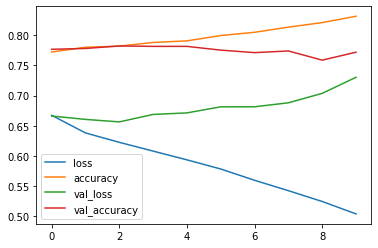

In [27]:
pd.DataFrame(history.history).plot()

97/97 [==============================] - 1s 11ms/step
       y_test  y_pred
idx                  
3566        2       1
1041        5       5
19546       5       4
3107        3       5
5173        5       5
...       ...     ...
8548        3       1
10792       5       5
19171       1       4
11365       5       5
7039        5       5

[6198 rows x 2 columns]


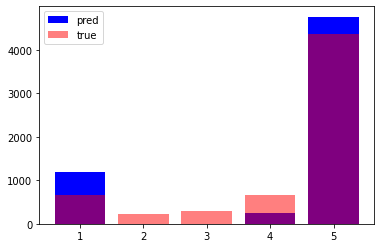

In [40]:
y_pred = model.predict(X_test_bow, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='blue', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='red', label='true')
plt.legend()
plt.show()


Вывод  
Видно, что сложнее всего моделе предсказывать средние оценки (2, 3, 4), возможно из-за того, что люди склонны ставить крайние значения, поэтому о них больше данных  
начиная с 3й похи наблюдается переобучение, по этой причине ранняя остановке прекратила обучение модели  

### 2. Предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?

In [29]:
import gensim.downloader as api
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [30]:
wv = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [31]:
def text_to_wv(text, maxlen):
    result = []
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum()]
    for w in words:
        if w in wv:
            result.append(list(wv[w]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [32]:
X_train_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_train])
X_test_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_test])

print(X_train_wv.shape)
print(X_test_wv.shape)

(14461, 132, 25)
(6198, 132, 25)


In [33]:
model = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [34]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_wv, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard] #early_stopping вылетает на первой эпохе, проучил на 10
)

score = model.evaluate(X_test_wv, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 4s 17ms/step - loss: 0.9629 - accuracy: 0.7083 - val_loss: 0.7760 - val_accuracy: 0.7574
Epoch 2/10
204/204 [==============================] - 3s 16ms/step - loss: 0.7408 - accuracy: 0.7521 - val_loss: 0.7200 - val_accuracy: 0.7623
Epoch 3/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6938 - accuracy: 0.7592 - val_loss: 0.6971 - val_accuracy: 0.7713
Epoch 4/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6706 - accuracy: 0.7679 - val_loss: 0.6897 - val_accuracy: 0.7706
Epoch 5/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6538 - accuracy: 0.7722 - val_loss: 0.6850 - val_accuracy: 0.7692
Epoch 6/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6356 - accuracy: 0.7774 - val_loss: 0.6795 - val_accuracy: 0.7678
Epoch 7/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6191 - accuracy: 0.7809 - val_loss: 0.6838 - val_accuracy: 0.7671

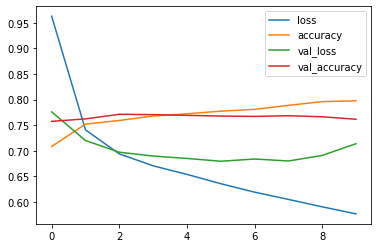

In [35]:
pd.DataFrame(history.history).plot()

97/97 [==============================] - 0s 4ms/step
       y_test  y_pred
idx                  
3566        2       1
1041        5       5
19546       5       5
3107        3       5
5173        5       5
...       ...     ...
8548        3       5
10792       5       5
19171       1       5
11365       5       5
7039        5       5

[6198 rows x 2 columns]


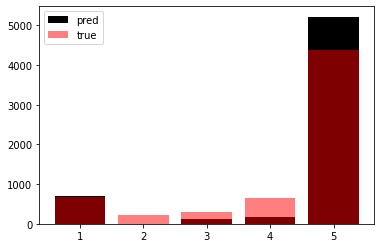

In [36]:
y_pred = model.predict(X_test_wv, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='black', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='red', label='true')
plt.legend()
plt.show()


Вывод:  
word2vec позволил продолжить обучение дольше чем при кастомной векторизации предложений  
при этом точность модели в итоге стала ниже  

In [37]:
df_score = pd.DataFrame(columns=['aggr']).set_index('aggr')

In [38]:
for key, val in {'q25': Q25_LEN, 'mean': MEAN_LEN, 'median': MEDIAN_LEN, 'q75': Q75_LEN, 'max': MAX_LEN}.items():
    
    display.clear_output(wait=False)
    
    model = models.Sequential([
        layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=val),
        layers.Conv1D(filters=128, kernel_size=3),
        layers.Activation('relu'),

        layers.GlobalMaxPool1D(),
        layers.Dense(10),
        layers.Activation('relu'),

        layers.Dense(NUM_CLASSES+1),
        layers.Activation('softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
    early_stopping = callbacks.EarlyStopping(monitor='val_loss')

    history = model.fit(
        X_train_bow, y_train_cat, 
        batch_size=5,
        epochs=5,
        verbose=1,
        validation_split=0.1,
        callbacks=[tensorboard] #вылетает на early_stopping проучил на 5 эпохах
    )

    score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

    df_score.loc['aggr', key] = score[1]

Epoch 1/5
2603/2603 [==============================] - 18s 7ms/step - loss: 0.7560 - accuracy: 0.7547 - val_loss: 0.7140 - val_accuracy: 0.7713
Epoch 2/5
2603/2603 [==============================] - 18s 7ms/step - loss: 0.6828 - accuracy: 0.7676 - val_loss: 0.6670 - val_accuracy: 0.7713
Epoch 3/5
2603/2603 [==============================] - 18s 7ms/step - loss: 0.6598 - accuracy: 0.7721 - val_loss: 0.6770 - val_accuracy: 0.7761
Epoch 4/5
2603/2603 [==============================] - 18s 7ms/step - loss: 0.6456 - accuracy: 0.7811 - val_loss: 0.6673 - val_accuracy: 0.7726
Epoch 5/5
97/97 [==============================] - 1s 11ms/step - loss: 0.6802 - accuracy: 0.7631


In [39]:
df_score

,q25,mean,median,q75,max
aggr,,,,,
aggr,0.761213,0.761052,0.745402,0.756212,0.763149



Вывод:
число слов в эмбендине практически не повлиятона на точность модели

+1 Conv

Epoch 1/10
204/204 [==============================] - 26s 123ms/step - loss: 0.8633 - accuracy: 0.7293 - val_loss: 0.6937 - val_accuracy: 0.7609
Epoch 2/10
204/204 [==============================] - 25s 121ms/step - loss: 0.6798 - accuracy: 0.7679 - val_loss: 0.6705 - val_accuracy: 0.7726
Epoch 3/10
204/204 [==============================] - 25s 121ms/step - loss: 0.6590 - accuracy: 0.7744 - val_loss: 0.6670 - val_accuracy: 0.7747
Epoch 4/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6428 - accuracy: 0.7792 - val_loss: 0.6598 - val_accuracy: 0.7768
Epoch 5/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6332 - accuracy: 0.7815 - val_loss: 0.6678 - val_accuracy: 0.7768
Epoch 6/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6181 - accuracy: 0.7874 - val_loss: 0.6722 - val_accuracy: 0.7733
Epoch 7/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6049 - accuracy: 0.7910 - val_loss: 0.6822 - val_ac

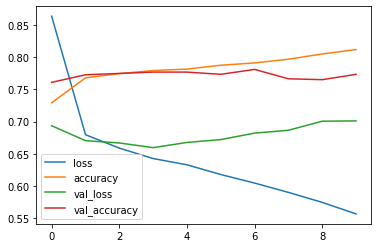

In [42]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Dense(10),
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()


Вывод:
скорость обучения упала

Dense out

Epoch 1/10
204/204 [==============================] - 26s 123ms/step - loss: 0.8033 - accuracy: 0.7437 - val_loss: 0.6899 - val_accuracy: 0.7630
Epoch 2/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6715 - accuracy: 0.7699 - val_loss: 0.6625 - val_accuracy: 0.7733
Epoch 3/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6471 - accuracy: 0.7765 - val_loss: 0.6654 - val_accuracy: 0.7768
Epoch 4/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6293 - accuracy: 0.7845 - val_loss: 0.6584 - val_accuracy: 0.7789
Epoch 5/10
204/204 [==============================] - 25s 121ms/step - loss: 0.6138 - accuracy: 0.7879 - val_loss: 0.6718 - val_accuracy: 0.7747
Epoch 6/10
204/204 [==============================] - 25s 122ms/step - loss: 0.5924 - accuracy: 0.7981 - val_loss: 0.6802 - val_accuracy: 0.7740
Epoch 7/10
204/204 [==============================] - 25s 121ms/step - loss: 0.5714 - accuracy: 0.8065 - val_loss: 0.6930 - val_ac

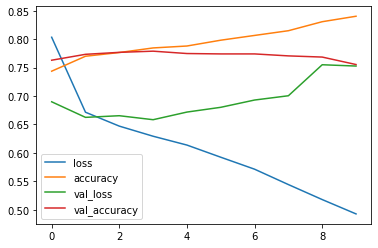

In [44]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()


Вывод:
без полносвязного слоя переобучение наступило раньше